## Simple MultiAI Agent Architecture

In [3]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [4]:
## Define the state
class AgentState(MessagesState):
    next_agent:str #which agent should go next

In [5]:
# Create simple tools
@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    # Using Tavily for web search
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content: str) -> str:
    """Write a summary of the provided content."""
    # Simple summary generation
    summary = f"Summary of findings:\n\n{content[:500]}..."
    return summary

In [6]:
from langchain.chat_models import init_chat_model

llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001FCE0DCF1A0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FCDD532540>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
# Define agent functions (simpler approach)
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    
    messages = state["messages"]
    
    # Add system message for context
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
    
    # Call LLM with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke([system_msg] + messages)
    
    # Return the response and route to writer
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [8]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""
    
    messages = state["messages"]
    
    # Add system message
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")
    
    # Simple completion without tools
    response = llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "end"
    }

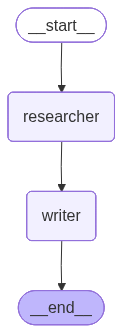

In [9]:
# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow

In [10]:
response=final_workflow.invoke({"messages":"Reasearch about the usecase of agentic ai in business"})

In [12]:
response

{'messages': [HumanMessage(content='Reasearch about the usecase of agentic ai in business', additional_kwargs={}, response_metadata={}, id='5221a874-9026-49cc-be1e-d6711115a957'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ytjrmh817', 'function': {'arguments': '{"query":"agentic AI in business use cases"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 243, 'total_tokens': 263, 'completion_time': 0.03193509, 'prompt_time': 0.013305647, 'queue_time': 0.050792268, 'total_time': 0.045240737}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--1457183f-4eaf-4673-badd-135483ca2a79-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'agentic AI in business use cases'}, 'id': 'ytjrmh817', 'type': 'tool_call'}], usage_metadata={'input_tokens': 243, '